# 高斯混合模型 (Gaussian Mixture Model, GMM)

## 📚 学习目标

1. 理解高斯混合模型的原理和EM算法
2. 掌握GMM与K-Means的区别和优势
3. 学会使用BIC/AIC选择最优的聚类数量
4. 实践GMM在不同数据分布上的应用
5. 了解GMM的协方差类型和应用场景

---

## 🎯 什么是高斯混合模型？

**高斯混合模型 (GMM)** 是一种基于概率的聚类算法，假设数据由多个高斯分布混合生成。

### 核心思想

- **K-Means**: 硬分配 (Hard Assignment) - 每个点属于一个簇
- **GMM**: 软分配 (Soft Assignment) - 每个点属于各个簇的概率

### 数学表示

$$P(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)$$

其中：
- $K$: 高斯分量数量
- $\pi_k$: 第k个分量的混合系数（权重）
- $\mu_k$: 第k个高斯分布的均值
- $\Sigma_k$: 第k个高斯分布的协方差矩阵

### EM算法

GMM使用EM (Expectation-Maximization) 算法迭代优化：

1. **E步 (Expectation)**: 计算每个样本属于各个高斯分量的后验概率
2. **M步 (Maximization)**: 更新每个高斯分量的参数（均值、协方差、权重）

In [8]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse

# 聚类算法
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# 数据生成和预处理
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler

# 评估指标
from sklearn.metrics import silhouette_score, adjusted_rand_score

import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 设置随机种子
np.random.seed(42)

---

## 1. GMM基础示例：生成混合高斯数据

数据形状: (300, 2)
真实类别数: 3


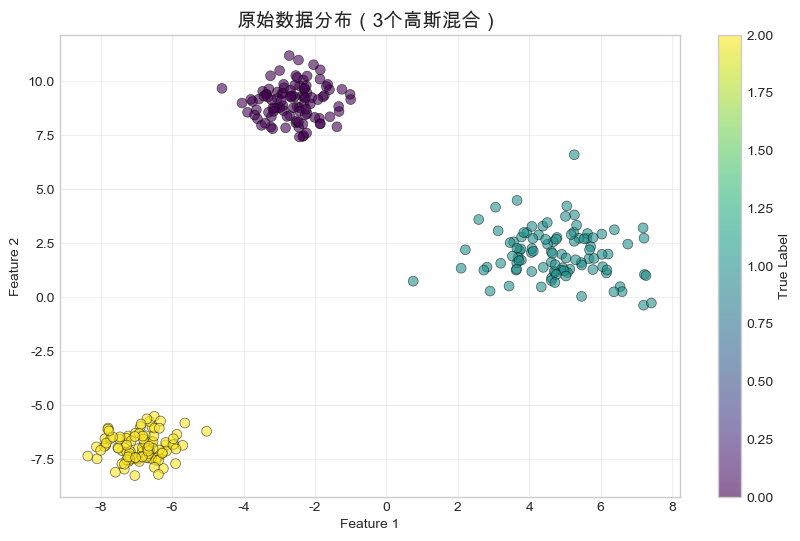

In [2]:
# 生成3个高斯分布混合的数据
X, y_true = make_blobs(n_samples=300, centers=3, 
                       cluster_std=[0.8, 1.2, 0.6],  # 不同的标准差
                       center_box=(-10, 10),
                       random_state=42)

print(f"数据形状: {X.shape}")
print(f"真实类别数: {len(np.unique(y_true))}")

# 可视化原始数据
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', 
           s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.title('原始数据分布（3个高斯混合）', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='True Label')
plt.grid(True, alpha=0.3)
plt.show()

---

## 2. 使用GMM进行聚类

### 关键参数

- `n_components`: 高斯分量数量（簇数量）
- `covariance_type`: 协方差类型
  - `'full'`: 每个分量有完整的协方差矩阵（默认）
  - `'tied'`: 所有分量共享一个协方差矩阵
  - `'diag'`: 对角协方差（特征独立）
  - `'spherical'`: 球形协方差（类似K-Means）
- `max_iter`: 最大迭代次数
- `random_state`: 随机种子

In [3]:
# 创建GMM模型
gmm = GaussianMixture(
    n_components=3,           # 3个高斯分量
    covariance_type='full',   # 完整协方差矩阵
    max_iter=100,
    random_state=42
)

# 训练模型
gmm.fit(X)

# 预测簇标签（硬分配）
y_gmm = gmm.predict(X)

# 获取概率（软分配）
y_gmm_proba = gmm.predict_proba(X)

print(f"是否收敛: {gmm.converged_}")
print(f"迭代次数: {gmm.n_iter_}")
print(f"\n模型参数:")
print(f"  均值 (means): \n{gmm.means_}")
print(f"\n  权重 (weights): {gmm.weights_}")
print(f"\n每个样本的概率分布示例（前5个）:")
print(pd.DataFrame(y_gmm_proba[:5], 
                   columns=[f'Cluster {i}' for i in range(3)]))

是否收敛: True
迭代次数: 2

模型参数:
  均值 (means): 
[[-2.60842567  9.03771305]
 [-6.88217395 -6.94243433]
 [ 4.76854828  2.01807919]]

  权重 (weights): [0.33333333 0.33333333 0.33333333]

每个样本的概率分布示例（前5个）:
       Cluster 0      Cluster 1     Cluster 2
0  3.843355e-100   1.000000e+00  5.721982e-41
1   6.498962e-98   1.000000e+00  8.070965e-41
2   1.000000e+00  3.534198e-145  6.560368e-12
3   3.299575e-35  2.048200e-126  1.000000e+00
4  4.615618e-104   1.000000e+00  3.881767e-44


---

## 3. 可视化GMM聚类结果

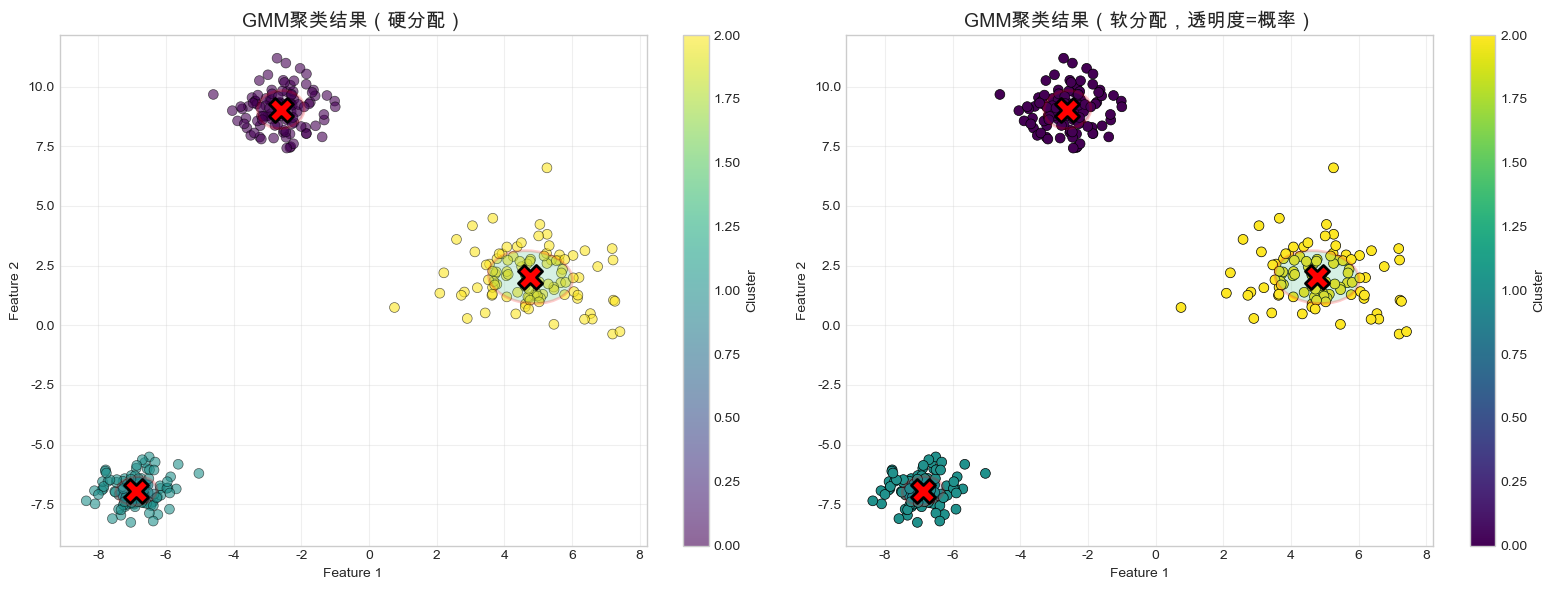

In [4]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """绘制高斯分布的协方差椭圆"""
    ax = ax or plt.gca()
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(eigenvalues)
    
    # 绘制椭圆（2倍标准差覆盖约95%数据）
    ellipse = Ellipse(position, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

# 绘制GMM聚类结果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左图: 硬分配
ax1 = axes[0]
scatter = ax1.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# 绘制高斯分布的椭圆
for i in range(3):
    draw_ellipse(gmm.means_[i], gmm.covariances_[i], ax1,
                alpha=0.2, facecolor=plt.cm.viridis(i/3), edgecolor='red', linewidth=2)
    # 标记均值点
    ax1.scatter(gmm.means_[i, 0], gmm.means_[i, 1], 
               c='red', marker='X', s=300, edgecolors='black', linewidth=2, zorder=10)

ax1.set_title('GMM聚类结果（硬分配）', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster')

# 右图: 软分配（显示概率）
ax2 = axes[1]
# 使用最大概率作为颜色深度
max_proba = y_gmm_proba.max(axis=1)
scatter2 = ax2.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='viridis', 
                      s=50, alpha=max_proba, edgecolors='black', linewidth=0.5)

# 绘制高斯分布的椭圆
for i in range(3):
    draw_ellipse(gmm.means_[i], gmm.covariances_[i], ax2,
                alpha=0.2, facecolor=plt.cm.viridis(i/3), edgecolor='red', linewidth=2)
    ax2.scatter(gmm.means_[i, 0], gmm.means_[i, 1], 
               c='red', marker='X', s=300, edgecolors='black', linewidth=2, zorder=10)

ax2.set_title('GMM聚类结果（软分配，透明度=概率）', fontsize=14, fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.show()

---

## 4. GMM vs K-Means 对比

### 关键区别

| 特性 | K-Means | GMM |
|------|---------|-----|
| **分配方式** | 硬分配（每个点属于一个簇） | 软分配（每个点属于各簇的概率） |
| **簇形状** | 球形（各向同性） | 椭圆形（可以是任意形状） |
| **算法** | 迭代优化距离 | EM算法优化似然 |
| **协方差** | 假设各簇方差相同 | 每个簇有自己的协方差矩阵 |
| **速度** | 快 | 相对较慢 |
| **灵活性** | 低 | 高 |

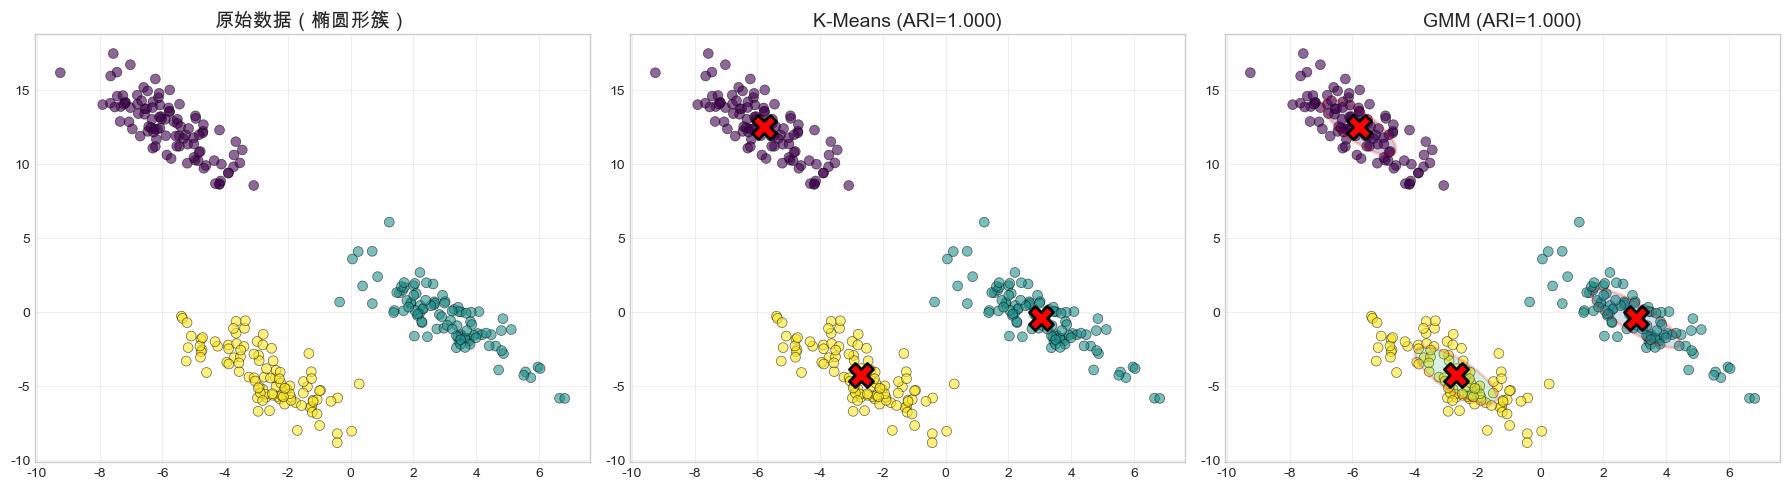


📊 性能对比:
K-Means:
  - ARI: 1.0000
  - Silhouette: 0.6928

GMM:
  - ARI: 1.0000
  - Silhouette: 0.6928

💡 GMM在椭圆形簇上表现更好！


In [5]:
# 生成椭圆形簇数据
from sklearn.datasets import make_blobs

# 生成拉伸的椭圆形簇
X_ellipse, y_true_ellipse = make_blobs(n_samples=300, centers=3, 
                                        cluster_std=1.5, random_state=42)

# 对数据进行拉伸变换，创建椭圆形簇
transformation = [[0.8, -0.6], [-0.4, 1.2]]
X_ellipse = np.dot(X_ellipse, transformation)

# K-Means聚类
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_ellipse)

# GMM聚类
gmm_ellipse = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
y_gmm_ellipse = gmm_ellipse.fit_predict(X_ellipse)

# 对比可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 原始数据
axes[0].scatter(X_ellipse[:, 0], X_ellipse[:, 1], c=y_true_ellipse, cmap='viridis',
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title('原始数据（椭圆形簇）', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# K-Means结果
axes[1].scatter(X_ellipse[:, 0], X_ellipse[:, 1], c=y_kmeans, cmap='viridis',
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               c='red', marker='X', s=300, edgecolors='black', linewidth=2, zorder=10)
axes[1].set_title(f'K-Means (ARI={adjusted_rand_score(y_true_ellipse, y_kmeans):.3f})', 
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# GMM结果
axes[2].scatter(X_ellipse[:, 0], X_ellipse[:, 1], c=y_gmm_ellipse, cmap='viridis',
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
for i in range(3):
    draw_ellipse(gmm_ellipse.means_[i], gmm_ellipse.covariances_[i], axes[2],
                alpha=0.2, facecolor=plt.cm.viridis(i/3), edgecolor='red', linewidth=2)
    axes[2].scatter(gmm_ellipse.means_[i, 0], gmm_ellipse.means_[i, 1],
                   c='red', marker='X', s=300, edgecolors='black', linewidth=2, zorder=10)
axes[2].set_title(f'GMM (ARI={adjusted_rand_score(y_true_ellipse, y_gmm_ellipse):.3f})', 
                 fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 性能对比:")
print(f"K-Means:")
print(f"  - ARI: {adjusted_rand_score(y_true_ellipse, y_kmeans):.4f}")
print(f"  - Silhouette: {silhouette_score(X_ellipse, y_kmeans):.4f}")
print(f"\nGMM:")
print(f"  - ARI: {adjusted_rand_score(y_true_ellipse, y_gmm_ellipse):.4f}")
print(f"  - Silhouette: {silhouette_score(X_ellipse, y_gmm_ellipse):.4f}")
print(f"\n💡 GMM在椭圆形簇上表现更好！")

---

## 5. 选择最优簇数量：BIC和AIC

### 信息准则

**AIC (Akaike Information Criterion)** 和 **BIC (Bayesian Information Criterion)** 用于模型选择：

$$AIC = -2 \log(L) + 2k$$
$$BIC = -2 \log(L) + k \log(n)$$

其中：
- $L$: 似然函数
- $k$: 参数数量
- $n$: 样本数量

**选择规则**: AIC/BIC **越小越好**（平衡拟合度和复杂度）

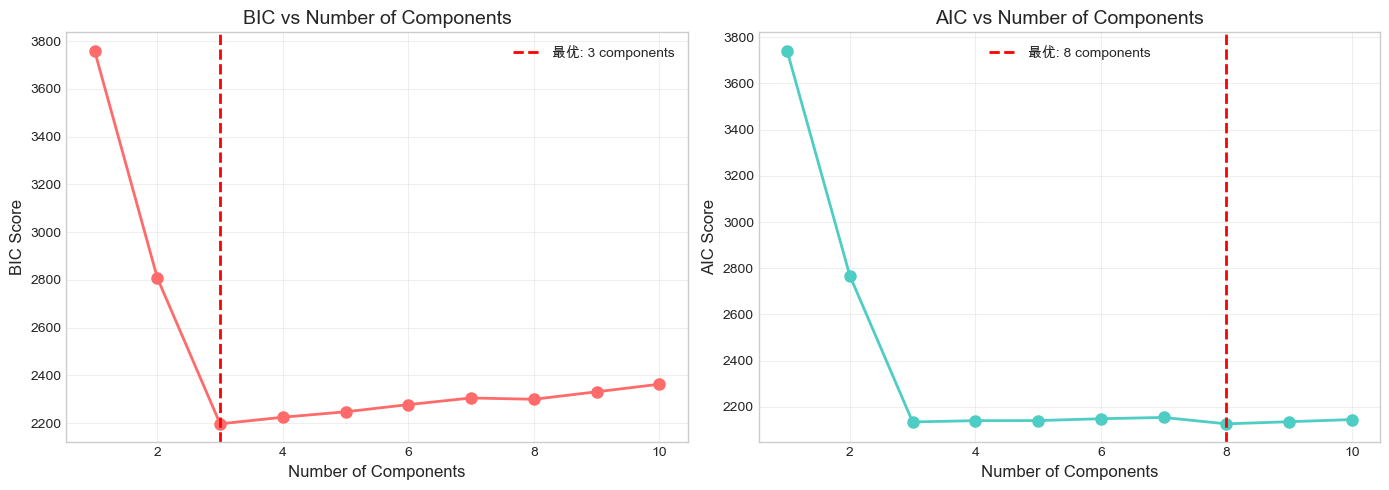


📊 最优簇数量:
  - BIC推荐: 3 components
  - AIC推荐: 8 components
  - 真实簇数: 3

💡 BIC对模型复杂度的惩罚更严格，通常选择更简单的模型


In [6]:
# 测试不同的簇数量
n_components_range = range(1, 11)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm_test = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm_test.fit(X)
    bic_scores.append(gmm_test.bic(X))
    aic_scores.append(gmm_test.aic(X))

# 可视化BIC和AIC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BIC
axes[0].plot(n_components_range, bic_scores, 'o-', linewidth=2, markersize=8, color='#FF6B6B')
best_bic_n = np.argmin(bic_scores) + 1
axes[0].axvline(best_bic_n, color='red', linestyle='--', linewidth=2, 
               label=f'最优: {best_bic_n} components')
axes[0].set_xlabel('Number of Components', fontsize=12)
axes[0].set_ylabel('BIC Score', fontsize=12)
axes[0].set_title('BIC vs Number of Components', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AIC
axes[1].plot(n_components_range, aic_scores, 'o-', linewidth=2, markersize=8, color='#4ECDC4')
best_aic_n = np.argmin(aic_scores) + 1
axes[1].axvline(best_aic_n, color='red', linestyle='--', linewidth=2, 
               label=f'最优: {best_aic_n} components')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('AIC Score', fontsize=12)
axes[1].set_title('AIC vs Number of Components', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 最优簇数量:")
print(f"  - BIC推荐: {best_bic_n} components")
print(f"  - AIC推荐: {best_aic_n} components")
print(f"  - 真实簇数: 3")
print(f"\n💡 BIC对模型复杂度的惩罚更严格，通常选择更简单的模型")

---

## 6. 协方差类型对比

不同的协方差类型适用于不同的数据分布：

- **full**: 每个分量有完整协方差矩阵（最灵活，参数最多）
- **tied**: 所有分量共享协方差矩阵（假设簇形状相同）
- **diag**: 对角协方差（假设特征独立）
- **spherical**: 球形协方差（类似K-Means，参数最少）

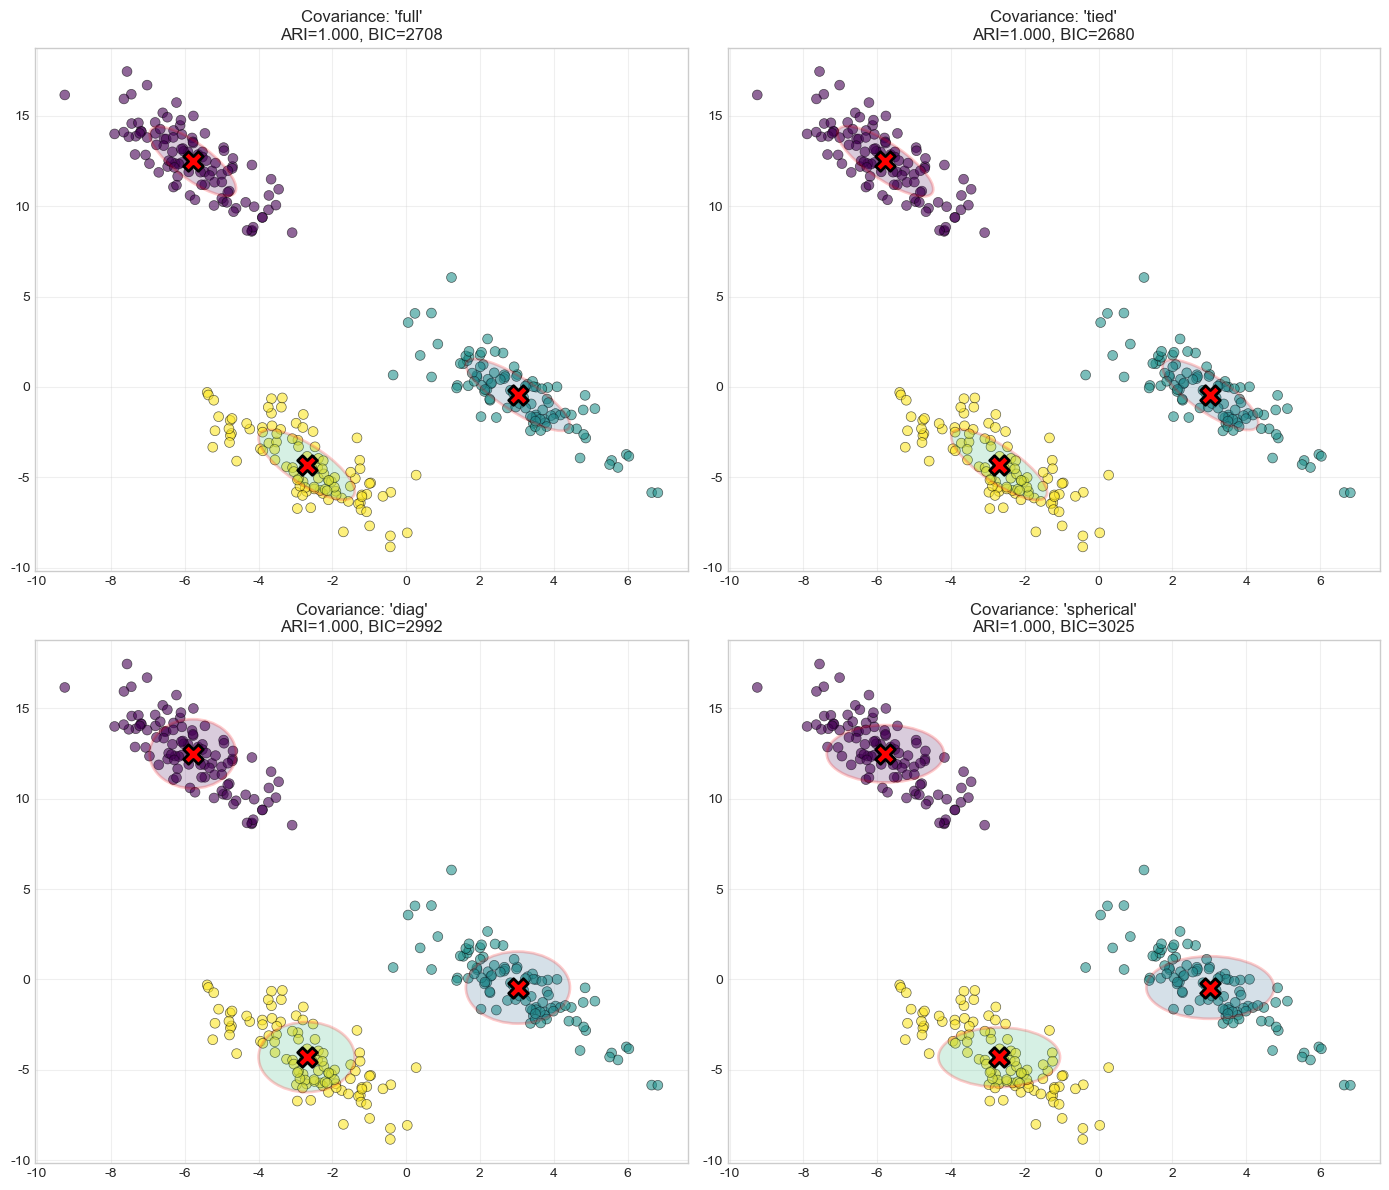


📊 协方差类型说明:
  - full: 最灵活，可以适应任意形状的椭圆，参数最多
  - tied: 所有簇形状相同，但可以旋转，参数较少
  - diag: 椭圆轴与坐标轴平行，不能旋转
  - spherical: 所有簇都是圆形，最简单，参数最少

💡 选择建议: 根据BIC选择，平衡拟合度和复杂度


In [9]:
# 测试不同协方差类型
covariance_types = ['full', 'tied', 'diag', 'spherical']
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, cov_type in enumerate(covariance_types):
    # 训练GMM
    gmm_cov = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    y_pred = gmm_cov.fit_predict(X_ellipse)
    
    # 可视化
    axes[idx].scatter(X_ellipse[:, 0], X_ellipse[:, 1], c=y_pred, cmap='viridis',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # 绘制椭圆
    if cov_type == 'tied':
        # tied类型所有分量共享一个协方差
        for i in range(3):
            draw_ellipse(gmm_cov.means_[i], gmm_cov.covariances_, axes[idx],
                        alpha=0.2, facecolor=plt.cm.viridis(i/3), edgecolor='red', linewidth=2)
    elif cov_type == 'full':
        # full类型每个分量有完整协方差矩阵
        for i in range(3):
            draw_ellipse(gmm_cov.means_[i], gmm_cov.covariances_[i], axes[idx],
                        alpha=0.2, facecolor=plt.cm.viridis(i/3), edgecolor='red', linewidth=2)
    elif cov_type == 'diag':
        # diag类型协方差是1维数组，需要转换成对角矩阵
        for i in range(3):
            cov_matrix = np.diag(gmm_cov.covariances_[i])
            draw_ellipse(gmm_cov.means_[i], cov_matrix, axes[idx],
                        alpha=0.2, facecolor=plt.cm.viridis(i/3), edgecolor='red', linewidth=2)
    else:  # spherical
        # spherical类型用圆形
        for i in range(3):
            cov_matrix = np.eye(2) * gmm_cov.covariances_[i]
            draw_ellipse(gmm_cov.means_[i], cov_matrix, axes[idx],
                        alpha=0.2, facecolor=plt.cm.viridis(i/3), edgecolor='red', linewidth=2)
    
    # 标记均值
    for i in range(3):
        axes[idx].scatter(gmm_cov.means_[i, 0], gmm_cov.means_[i, 1],
                         c='red', marker='X', s=200, edgecolors='black', linewidth=2, zorder=10)
    
    # 计算评估指标
    ari = adjusted_rand_score(y_true_ellipse, y_pred)
    bic = gmm_cov.bic(X_ellipse)
    
    axes[idx].set_title(f"Covariance: '{cov_type}'\nARI={ari:.3f}, BIC={bic:.0f}",
                       fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 协方差类型说明:")
print("  - full: 最灵活，可以适应任意形状的椭圆，参数最多")
print("  - tied: 所有簇形状相同，但可以旋转，参数较少")
print("  - diag: 椭圆轴与坐标轴平行，不能旋转")
print("  - spherical: 所有簇都是圆形，最简单，参数最少")
print("\n💡 选择建议: 根据BIC选择，平衡拟合度和复杂度")

---

## 7. 实战案例：GMM用于异常检测

GMM可以通过计算样本的对数似然来检测异常点：
- 高似然 → 正常点
- 低似然 → 异常点

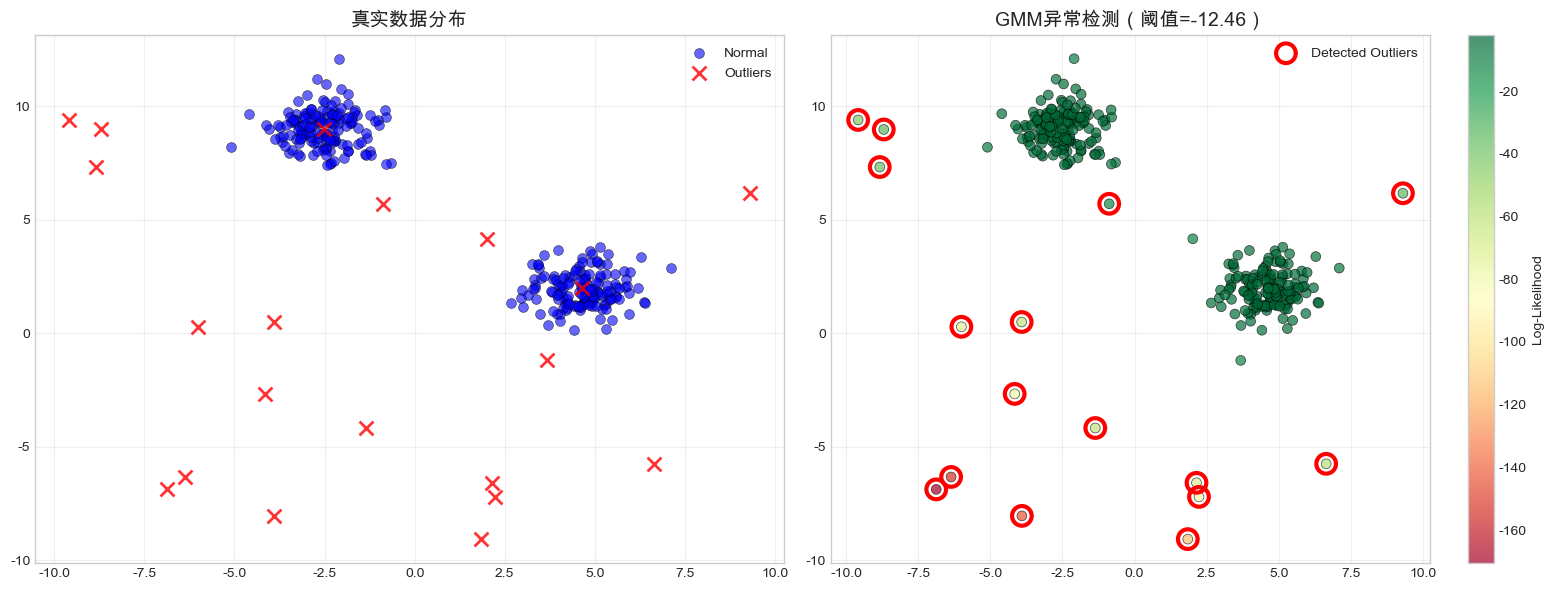


📊 异常检测性能:
              precision    recall  f1-score   support

      Normal      0.987     1.000     0.993       300
     Outlier      1.000     0.800     0.889        20

    accuracy                          0.988       320
   macro avg      0.993     0.900     0.941       320
weighted avg      0.988     0.988     0.987       320



In [10]:
# 生成数据并添加异常点
X_normal, _ = make_blobs(n_samples=300, centers=2, cluster_std=0.8, random_state=42)

# 添加异常点
np.random.seed(42)
X_outliers = np.random.uniform(low=-10, high=10, size=(20, 2))
X_with_outliers = np.vstack([X_normal, X_outliers])

# 训练GMM
gmm_outlier = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_outlier.fit(X_normal)  # 只用正常数据训练

# 计算每个点的对数似然
log_likelihood = gmm_outlier.score_samples(X_with_outliers)

# 设置阈值（使用分位数）
threshold = np.percentile(log_likelihood, 5)  # 最低5%为异常
is_outlier = log_likelihood < threshold

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左图: 数据分布
axes[0].scatter(X_normal[:, 0], X_normal[:, 1], c='blue', 
               s=50, alpha=0.6, label='Normal', edgecolors='black', linewidth=0.5)
axes[0].scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', 
               s=100, alpha=0.8, label='Outliers', marker='x', linewidth=2)
axes[0].set_title('真实数据分布', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 右图: 异常检测结果
scatter = axes[1].scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], 
                         c=log_likelihood, cmap='RdYlGn',
                         s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].scatter(X_with_outliers[is_outlier, 0], X_with_outliers[is_outlier, 1],
               facecolors='none', edgecolors='red', s=200, linewidths=3, label='Detected Outliers')
axes[1].set_title(f'GMM异常检测（阈值={threshold:.2f}）', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Log-Likelihood')

plt.tight_layout()
plt.show()

# 评估异常检测效果
true_outliers = np.zeros(len(X_with_outliers), dtype=bool)
true_outliers[-20:] = True  # 最后20个是异常点

from sklearn.metrics import classification_report
print("\n📊 异常检测性能:")
print(classification_report(true_outliers, is_outlier, 
                           target_names=['Normal', 'Outlier'], digits=3))

---

## 8. GMM的概率密度可视化

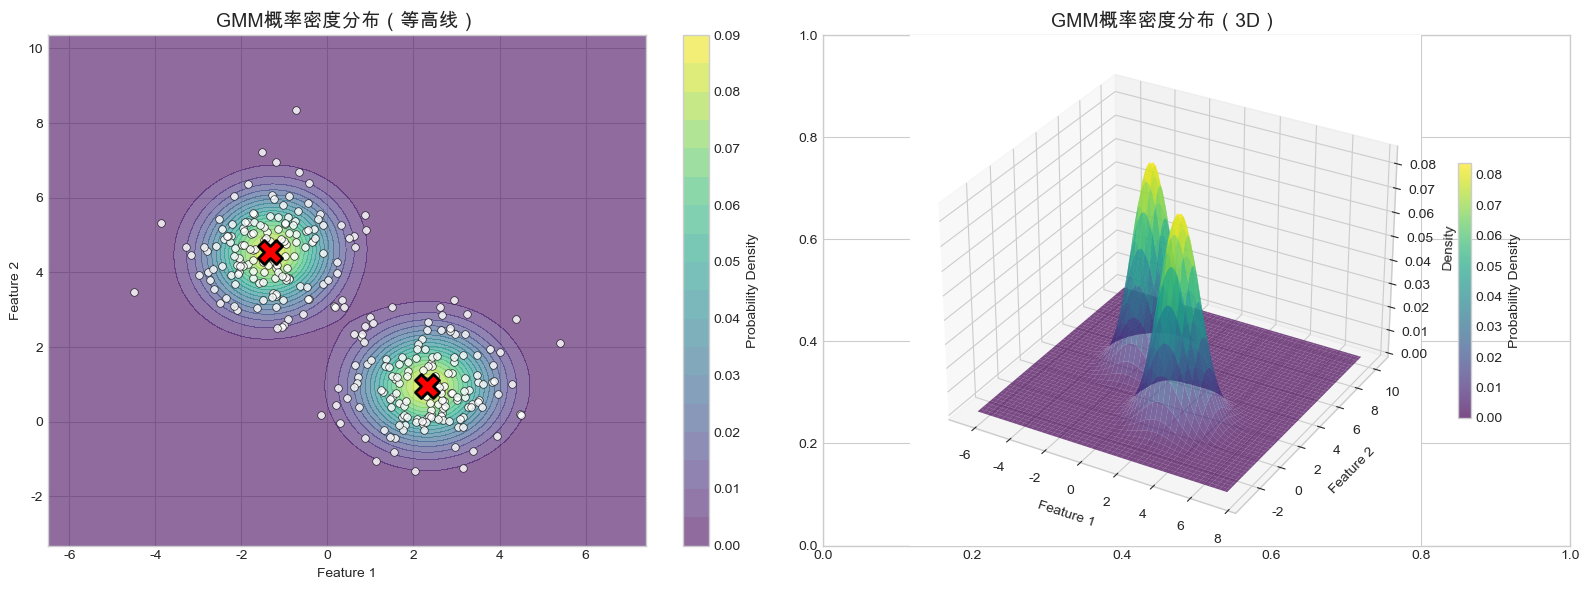

In [11]:
# 使用简单数据生成GMM
X_simple, _ = make_blobs(n_samples=300, centers=2, cluster_std=1.0, 
                        center_box=(-5, 5), random_state=42)

gmm_simple = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_simple.fit(X_simple)

# 创建网格
x_min, x_max = X_simple[:, 0].min() - 2, X_simple[:, 0].max() + 2
y_min, y_max = X_simple[:, 1].min() - 2, X_simple[:, 1].max() + 2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# 计算每个网格点的对数似然
Z = gmm_simple.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 转换为概率密度
density = np.exp(Z)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左图: 等高线图
contour = axes[0].contourf(xx, yy, density, levels=20, cmap='viridis', alpha=0.6)
axes[0].scatter(X_simple[:, 0], X_simple[:, 1], c='white', 
               s=30, alpha=0.8, edgecolors='black', linewidth=0.5)
axes[0].scatter(gmm_simple.means_[:, 0], gmm_simple.means_[:, 1],
               c='red', marker='X', s=300, edgecolors='black', linewidth=2, zorder=10)
axes[0].set_title('GMM概率密度分布（等高线）', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
plt.colorbar(contour, ax=axes[0], label='Probability Density')

# 右图: 3D表面图
from mpl_toolkits.mplot3d import Axes3D
ax2 = fig.add_subplot(122, projection='3d')
surf = ax2.plot_surface(xx, yy, density, cmap='viridis', alpha=0.7, edgecolor='none')
ax2.set_title('GMM概率密度分布（3D）', fontsize=14, fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Density')
plt.colorbar(surf, ax=ax2, shrink=0.5, label='Probability Density')

plt.tight_layout()
plt.show()

---

## 9. GMM实战：Iris数据集

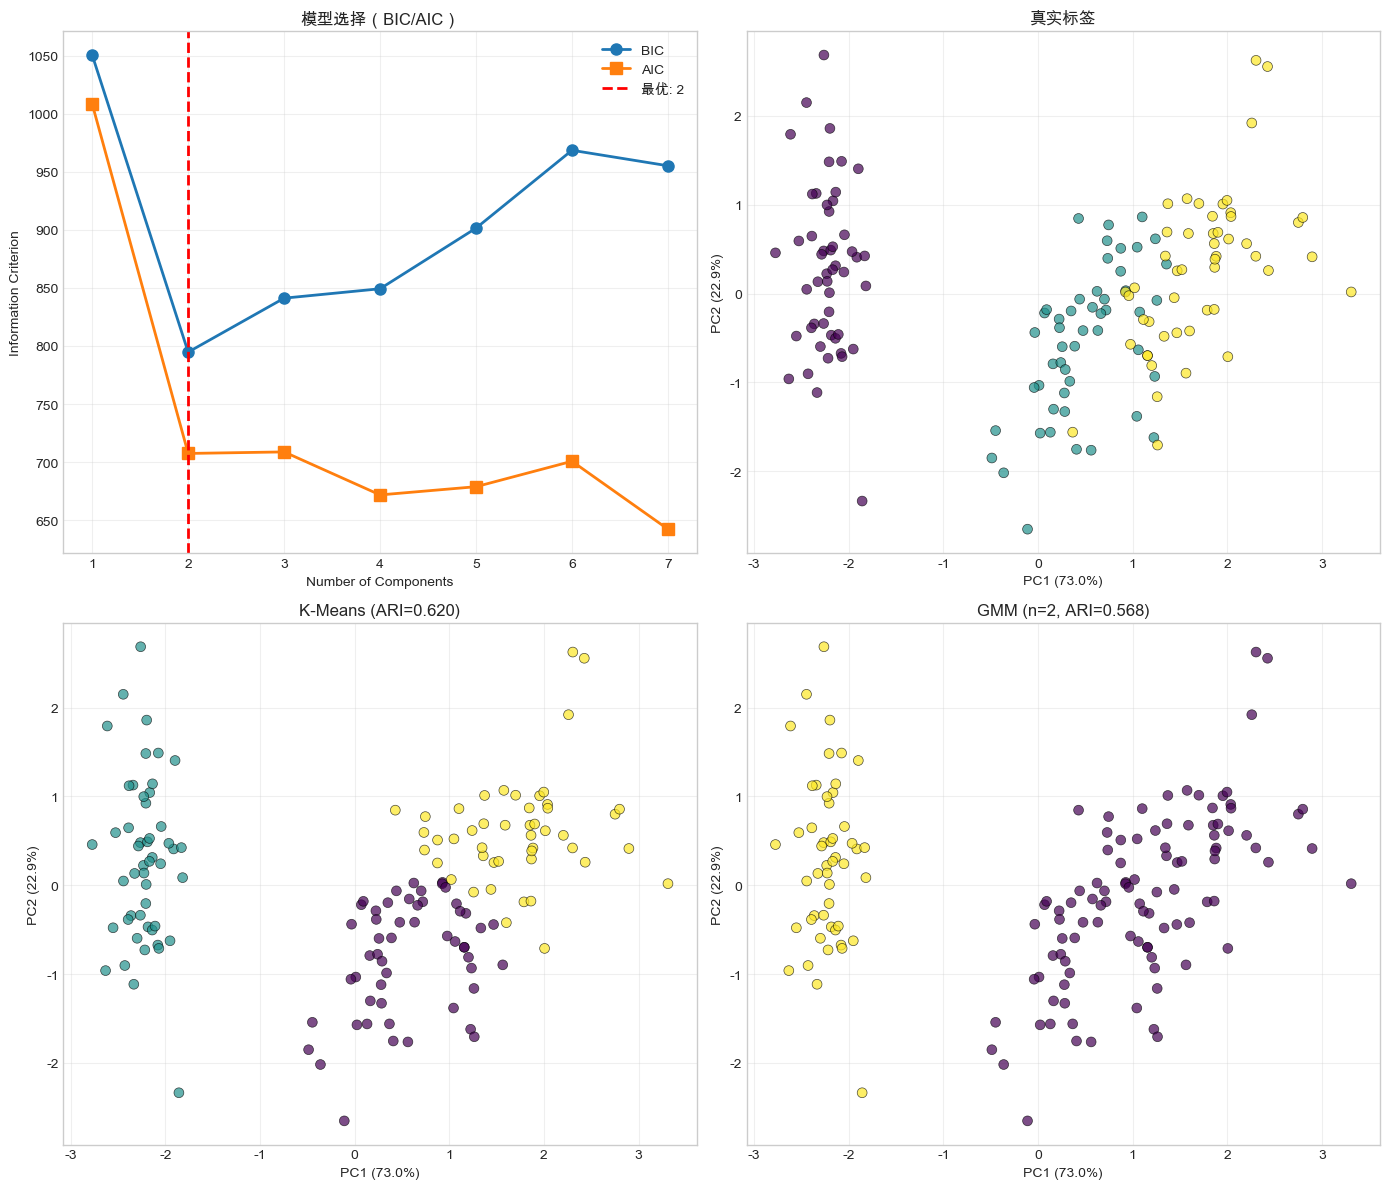


📊 Iris数据集聚类结果:
  - 最优组件数（BIC）: 2
  - K-Means ARI: 0.6201
  - GMM ARI: 0.5681

  - K-Means Silhouette: 0.4599
  - GMM Silhouette: 0.5818


In [12]:
from sklearn.datasets import load_iris

# 加载Iris数据
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# 标准化
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# PCA降维用于可视化
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_iris_pca = pca.fit_transform(X_iris_scaled)

# 使用BIC选择最优组件数
n_components_range = range(1, 8)
bic_iris = []
aic_iris = []

for n in n_components_range:
    gmm_test = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm_test.fit(X_iris_scaled)
    bic_iris.append(gmm_test.bic(X_iris_scaled))
    aic_iris.append(gmm_test.aic(X_iris_scaled))

best_n = np.argmin(bic_iris) + 1

# 使用最优组件数训练GMM
gmm_iris = GaussianMixture(n_components=best_n, covariance_type='full', random_state=42)
y_gmm_iris = gmm_iris.fit_predict(X_iris_scaled)
y_gmm_proba_iris = gmm_iris.predict_proba(X_iris_scaled)

# K-Means对比
kmeans_iris = KMeans(n_clusters=3, random_state=42, n_init=10)
y_kmeans_iris = kmeans_iris.fit_predict(X_iris_scaled)

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# BIC/AIC曲线
axes[0, 0].plot(n_components_range, bic_iris, 'o-', label='BIC', linewidth=2, markersize=8)
axes[0, 0].plot(n_components_range, aic_iris, 's-', label='AIC', linewidth=2, markersize=8)
axes[0, 0].axvline(best_n, color='red', linestyle='--', linewidth=2, label=f'最优: {best_n}')
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Information Criterion')
axes[0, 0].set_title('模型选择（BIC/AIC）', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 真实标签
axes[0, 1].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_iris, cmap='viridis',
                  s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0, 1].set_title('真实标签', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0, 1].grid(True, alpha=0.3)

# K-Means结果
axes[1, 0].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_kmeans_iris, cmap='viridis',
                  s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ari_kmeans = adjusted_rand_score(y_iris, y_kmeans_iris)
axes[1, 0].set_title(f'K-Means (ARI={ari_kmeans:.3f})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1, 0].grid(True, alpha=0.3)

# GMM结果
axes[1, 1].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_gmm_iris, cmap='viridis',
                  s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ari_gmm = adjusted_rand_score(y_iris, y_gmm_iris)
axes[1, 1].set_title(f'GMM (n={best_n}, ARI={ari_gmm:.3f})', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Iris数据集聚类结果:")
print(f"  - 最优组件数（BIC）: {best_n}")
print(f"  - K-Means ARI: {ari_kmeans:.4f}")
print(f"  - GMM ARI: {ari_gmm:.4f}")
print(f"\n  - K-Means Silhouette: {silhouette_score(X_iris_scaled, y_kmeans_iris):.4f}")
print(f"  - GMM Silhouette: {silhouette_score(X_iris_scaled, y_gmm_iris):.4f}")

---

## 📝 总结

### GMM的优势

✅ **软分配**: 提供每个点属于各簇的概率，更符合实际

✅ **灵活性**: 可以适应椭圆形簇，不局限于球形

✅ **概率框架**: 基于概率模型，有严格的数学基础

✅ **模型选择**: 通过BIC/AIC自动选择最优簇数

✅ **多用途**: 可用于聚类、密度估计、异常检测

### GMM的局限

⚠️ **计算复杂**: 比K-Means慢，尤其是full协方差

⚠️ **参数敏感**: 需要选择协方差类型和初始化方法

⚠️ **高斯假设**: 假设数据服从高斯分布，不适合非高斯数据

⚠️ **局部最优**: EM算法可能陷入局部最优

### 使用建议

1. **数据形状**: 如果簇形状不规则（椭圆形），优先考虑GMM
2. **需要概率**: 如果需要软分配或不确定性度量，使用GMM
3. **簇数未知**: 使用BIC/AIC选择最优簇数
4. **大规模数据**: 如果数据量很大，K-Means更快
5. **协方差选择**: 
   - 簇形状各异 → `full`
   - 簇形状相似 → `tied`
   - 特征独立 → `diag`
   - 球形簇 → `spherical`

### 关键参数

```python
GaussianMixture(
    n_components=3,          # 簇数量
    covariance_type='full',  # 协方差类型
    max_iter=100,            # 最大迭代次数
    n_init=1,                # 初始化次数
    init_params='kmeans',    # 初始化方法
    random_state=42          # 随机种子
)
```

---

## 🎓 练习建议

1. 尝试不同的协方差类型，观察效果差异
2. 在自己的数据集上使用BIC/AIC选择最优簇数
3. 对比GMM和K-Means在不同数据分布上的表现
4. 使用GMM进行异常检测实验
5. 分析软分配的概率分布，理解模型的不确定性

---

**下一步**: 继续学习 `04_pca_dimensionality_reduction.ipynb`